In [ ]:
# Alex Dvornikov
# HW5 
# Neural Network "From Scratch"
# April 19, 2020

In [356]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import optimize

import sklearn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Change Jupyter Notebook cell width 
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:75% !important; }</style>"))

In [357]:
# Network Layout (each line is a layer)
layout = [
    {"in_size": in_size, "out_size": 100, "activation": "relu"},
    {"in_size": 100, "out_size": 100, "activation": "relu"},
    {"in_size": 100, "out_size": 1, "activation": "sigmoid"},
]


def setup_params(layout):
    # number_of_layers = len(layout)
    # Initiate parameters
    params = {}
    
    # Iterate over the layers
    for idx, layer in enumerate(layout):
        # Start enumration from 1
        layer_idx = idx + 1
        
        # Get the input and output sizes of the layers
        layer_in_size = layer["in_size"]
        layer_out_size = layer["out_size"]
        
        # Initiate W (matrix) and b (vector) 
        # Multiply by 0.1 to force small initial weights 
        params['W' + str(layer_idx)] = np.random.randn(layer_out_size, layer_in_size) * 0.1
        params['b' + str(layer_idx)] = np.random.randn(layer_out_size, 1) * 0.1
        
    return params

In [358]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

# Partial derivatives for backprop
# For more look inside the'bp_layer' function below
def sigmoid_back(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_back(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

# 'A' stands for Activation and 'dA' is derivative respect to the activation 
# In our notes we called it 'x' for the first layer and 'h' for the subsequent layers.
# For the top layer it was yhat. 

In [359]:
# Forward propagate through a single layer 
def fp_layer(A_prev, W_curr, b_curr, activation="relu"):
    # Calculate input to the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # Select activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
        
    # Return the output and input of the activation function
    return activation_func(Z_curr), Z_curr

In [360]:
# Forward propagate through all the layers 
def fp_all(X, params, layout):
    # Initiate a dictionary for info needed for backprop
    memory = {}
    # X (vector) is the bottom layer 
    A_curr = X
    
    # Iterate over layers
    for idx, layer in enumerate(layout):
        # Number the layers from 1
        layer_idx = idx + 1
        # Get the activation output from the previous layer
        A_prev = A_curr
        
        # Get the activation function, the weights matrix, and the bias vector for the current layer
        activation_curr = layer["activation"]
        W_curr = params["W" + str(layer_idx)]
        b_curr = params["b" + str(layer_idx)]
        # Calculate the activation for the current layer
        A_curr, Z_curr = fp_layer(A_prev, W_curr, b_curr, activation_curr)
        
        # Save
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # Return the output of the activation and a dictionary of the intermediate values
    return A_curr, memory

In [361]:
# Back propagate through a single layer 
def bp_layer(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # Number of examples
    m = A_prev.shape[1]
    
    # Get the activation function
    if activation is "relu":
        back_activation_func = relu_back
    elif activation is "sigmoid":
        back_activation_func = sigmoid_back
    
    # Calculate its derivative
    dZ_curr = back_activation_func(dA_curr, Z_curr)
    
    # Chain Rule
    # Calcualte the derivatives respect to the W (matrix), b (vector), and A_prev (matrix)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [362]:
# Back propagate through all the layers 
def bp_all(Y_hat, Y, memory, params, layout):
    # Initiate a dictionary for the gradients 
    grads = {}
    # Number of examples
    m = Y.shape[1]
    # Force the predictions and the labels to be of the same shape
    Y = Y.reshape(Y_hat.shape)
    
    # Derivative of the loss respect to the prediction (part of the chain rule)
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    # Start from the end
    for layer_idx_prev, layer in reversed(list(enumerate(layout))):
        # The layers are numbered from 1
        layer_idx_curr = layer_idx_prev + 1
        # Get the activation function for the current layer
        activation_curr = layer["activation"]

        dA_curr = dA_prev
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params["W" + str(layer_idx_curr)]
        b_curr = params["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = bp_layer(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_curr)
        
        grads["dW" + str(layer_idx_curr)] = dW_curr
        grads["db" + str(layer_idx_curr)] = db_curr
    
    return grads

In [363]:
def update(params, grads, layout, learning_rate):
    # Gradient descent 

    # Iterate over the layers
    for layer_idx, layer in enumerate(layout, 1):
        params["W" + str(layer_idx)] -= learning_rate * grads["dW" + str(layer_idx)]        
        params["b" + str(layer_idx)] -= learning_rate * grads["db" + str(layer_idx)]

    return params;

In [364]:
# Calculate the binary cross entropy loss 
def calc_loss(Y_hat, Y):
    # Number of examples
    m = Y_hat.shape[1]
    loss = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    # Remove extra brackets in the array
    return np.squeeze(loss)

# Convert probabiliies into binary classes 
def prob_to_binary(probs):
    # Copy probs to prob (a snapshot copy that won't change if probs changes)
    prob = np.copy(probs)
    prob[prob > 0.5] = 1
    prob[prob <= 0.5] = 0
    return prob

# Get the accuracy 
def calc_accuracy(Y_hat, Y):
    Y_hat_ = prob_to_binary(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [387]:
def train(X, Y, layout, epochs, learning_rate, verbose=True, callback=None):
    # Initiate parameters 
    params = setup_params(layout)
    # Initiate lists to track learning   
    loss_list = []
    accuracy_list = []
    
    # Iterate over epochs 
    for i in range(epochs):
        # Step ahead
        Y_hat, cache = fp_all(X, params, layout)
        
        # Get learning metrics and store them
        loss = calc_loss(Y_hat, Y)
        loss_list.append(loss)
        accuracy = calc_accuracy(Y_hat, Y)
        accuracy_list.append(accuracy)
        
        # Backprop
        grads = bp_all(Y_hat, Y, cache, params, layout)
        # Update params 
        params = update(params, grads, layout, learning_rate)
        
        # Print learning metrics (every 50 epochs)
        if(i % 50 == 0):
            if(verbose): # Set verbose = True to print the metrics 
                print("Iteration: {:05} - loss: {:.5f} - accuracy: {:.5f}".format(i, loss, accuracy))
            if(callback is not None):
                callback(i, params)
            
    return params

In [ ]:
#####################################################################################################################

In [366]:
# Get training and test data

# Download Tox21 data set.
# !curl -LO http://bioinf.jku.at/research/DeepTox/tox21_dense_train.csv.gz
# !gunzip tox21_dense_train.csv.gz 
# !curl -LO http://bioinf.jku.at/research/DeepTox/tox21_labels_train.csv.gz
# !gunzip tox21_labels_train.csv.gz
# !curl -LO http://bioinf.jku.at/research/DeepTox/tox21_dense_test.csv.gz
# !curl -LO http://bioinf.jku.at/research/DeepTox/tox21_labels_test.csv.gz
# !gunzip tox21_dense_test.csv.gz
# !gunzip tox21_labels_test.csv.gz

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = pd.read_csv('tox21_dense_train.csv')
X_train = np.array(X_train.iloc[:,1:])
scaler.fit(X_train)
X_train = scaler.transform(X_train)
in_size = X_train.shape[1]

y_train = pd.read_csv('tox21_labels_train.csv')
y_train = y_train.fillna(0)
y_train = np.array(y_train.loc[:,'NR.AR']) # Each Column is a type of toxicity.

X_test = pd.read_csv('tox21_dense_test.csv')
X_test = np.array(X_test.iloc[:,1:])
X_test = scaler.transform(X_test) # Must use exact same preprocessing as train set.

y_test = pd.read_csv('tox21_labels_test.csv')
y_test = y_test.fillna(0)
y_test = np.array(y_test.loc[:,'NR.AR']) 

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [388]:
# Train
params = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), layout, 500, 0.2)

Iteration: 00000 - loss: 1.12800 - accuracy: 0.10605
Iteration: 00050 - loss: 0.10593 - accuracy: 0.96940
Iteration: 00100 - loss: 0.09695 - accuracy: 0.97247
Iteration: 00150 - loss: 0.09206 - accuracy: 0.97430
Iteration: 00200 - loss: 0.08847 - accuracy: 0.97438
Iteration: 00250 - loss: 0.08538 - accuracy: 0.97512
Iteration: 00300 - loss: 0.08262 - accuracy: 0.97537
Iteration: 00350 - loss: 0.08005 - accuracy: 0.97579
Iteration: 00400 - loss: 0.07757 - accuracy: 0.97612
Iteration: 00450 - loss: 0.07517 - accuracy: 0.97653


In [389]:
# Predict
Y_test_hat, _ = fp_all(np.transpose(X_test), params, layout)

# Accuracy on the test set
acc_test = accuracy(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))


pred = Y_test_hat.reshape(y_test.shape)
auc_test = roc_auc_score(y_test, pred)
print("Test set accuracy: {:.2f}".format(acc_test))
print("Test set AUC: %3.5f" % (auc_test))

Test set accuracy: 0.98
Test set AUC: 0.77021


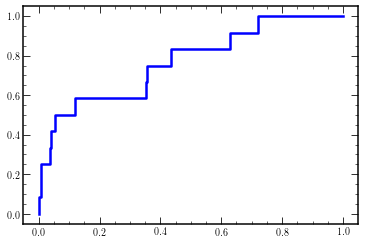

In [391]:
# ROC Curve 
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
plt.plot(fpr, tpr, color='blue')
plt.show()

In [372]:
# Compare to neural network from Sklearn 
# The network "from scratch" can outperform the MLP classifier in Sklearn
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,100), random_state=1, max_iter=100)


# Evaluate on test set.
model.fit(X_train, y_train)
p_te = model.predict_proba(X_test)
auc_te = roc_auc_score(y_test, p_te[:, 1])
print("Test set AUC: %3.5f" % (auc_te))

Test set AUC: 0.73491
